In [ ]:

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
import argparse 
from google.colab import drive
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from __future__ import print_function
import torch, os, copy, time, pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob, pickle
import seaborn as sn
import argparse
start_time= time.time()
import pandas as pd
import numpy as np
import random
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.io import imread
import PIL
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir='/content/gdrive/MyDrive/data3/'

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) , 
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batch_size,
                                             shuffle=True, num_workers= num_workers)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes  


In [ ]:
import cv2
import os
from PIL import Image

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
      

        im = Image.open(os.path.join(folder,filename))
        img = cv2.imread(os.path.join(folder,filename))
        if im is not None:
            images.append(im)
    return images

In [ ]:
sm = torch.nn.Softmax()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
start_time= time.time()
epochs = 100
batch_size =20 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs= 20):
    since = time.time()
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc

In [ ]:

def testmodel(testimage , cut_off_threshold):
  print('test size is : ' ,len(testimage) , 'sample')
  coivdpred = list()
  noncovidpred = list()
  totalpred = list()
  grandth = list()

  for  inputs, labels in testimage :
    cur_img = inputs.reshape(1 , 3 , 224,224)
    out = model(cur_img)
    cur_prob2 = sm(out)

    if float(cur_prob2[0][0])> cut_off_threshold:
      out2 = 0 
      coivdpred.append(0)
      totalpred.append(out2)
      grandth.append(labels)

    else:
      out2 = 1 
      totalpred.append(out2)
      noncovidpred.append(1)
      grandth.append(labels)

  covid_prob = list() 
  non_prob = list()
  for  inputs, labels in testimage:
    cur_img = inputs.reshape(1 , 3 , 224,224)
    out = model(cur_img)
    cur_prob = sm(out)
    if labels == 0 :
        covid_prob.append(cur_prob.data.numpy()[0,0])
    if labels == 1 :
        non_prob.append(cur_prob.data.numpy()[0,0])
  k = 0
  for i in range(3100):
    if grandth[i] == 0 :
      if totalpred[i] == 1:
        k = k+1
  print('num of samples covid but predicted non covid :' ,k)
  l = 0
  for i in range(3100):
    if grandth[i] == 1 :
      if totalpred[i] == 0:
        l = l+1
  print('num of samples non covid but predicted covid :' , l)
  print('total cases that predicted as covid: ' , len(coivdpred))
  sensivity = (100 - k) / 100
  print('total cases that predicted as non covid :' ,len(noncovidpred))
  Specificity =  (3000 - l) / 3000
  print('Sensitivity is :',sensivity)
  print('Specificity is :', Specificity)
  ConfusionMatrix(totalpred , grandth)
  return covid_prob , non_prob ,coivdpred , noncovidpred


In [ ]:
def Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, cut_off_threshold):
  y_test_res18= [1 for i in range(len(covid_prob))]+[0 for i in range(len(non_prob))]
  y_pred_res18= [1 for i in range(len(coivdpred))]+[0 for i in range(len(noncovidpred))]

           
  auc_res18 = roc_auc_score(y_test_res18, y_pred_res18)
  ns_fpr_res18, ns_tpr_res18, _ = roc_curve(y_test_res18, y_pred_res18)

  plt.figure()
  pyplot.plot(ns_fpr_res18, ns_tpr_res18,  color='darkgreen', linewidth=2,   label='   AUC= %.3f'   %auc_res18) 
  pyplot.ylim([0,1.05])
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.title("ROC Curve threshold is %.2f "  %cut_off_threshold)
  pyplot.legend(loc='lower right')
  # plt.savefig('./ROC_covid19.png') 

In [ ]:
def Probabilties(covid_prob ,non_prob ):
  bins = np.linspace(0, 1, 25)
  plt.subplot(211)
  plt.hist(covid_prob, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
  plt.ylim([0,10])
  plt.legend(loc='upper center')
  plt.subplot(212)
  plt.hist(non_prob, bins, color= 'green', label='Probabilities of Non-COVID Samples')
  plt.legend(loc='upper center')
  plt.savefig('./scores_histogram.png') 

In [ ]:
def ConfusionMatrix(totalpred , grandth):
  y_pred= np.asarray(totalpred, dtype=np.int64)
  y_test= np.asarray(grandth, dtype=np.int64)
  cnf_matrix = confusion_matrix(y_test, y_pred)
  np.set_printoptions(precision=2)   
  df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                 columns = [i for i in class_names])
  ax = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['COVID','Non-COVID'], yticklabels= ['COVID','Non-COVID'])
  ax.set_title("Confusion matrix")




# **2nd ResNet50**

In [ ]:
#### load model
model_conv = torchvision.models.resnet50(pretrained=True)
i = 0 
for child  in model_conv.children():
        i = i +1
        if i >= 8 :
          for param in child.parameters():
              param.requires_grad = True
        else:
          for param in child.parameters():
              param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet50_100_2.pt' )




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_resnet50_unet.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']

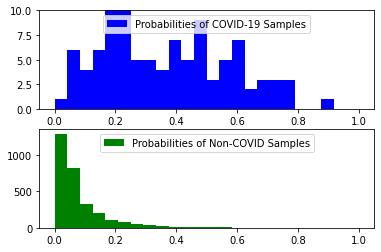

In [ ]:
Probabilties(covid_prob , non_prob)

## **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 15
num of samples non covid but predicted covid : 424
total cases that predicted as covid:  509
total cases that predicted as non covid : 2591
Sensitivity is : 0.85
Specificity is : 0.8586666666666667


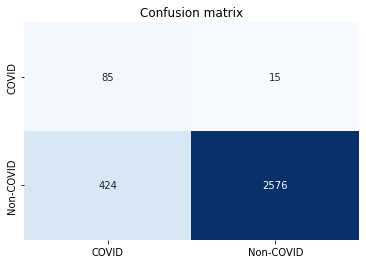

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

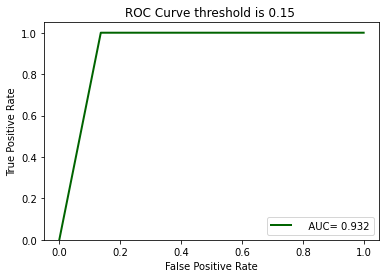

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

## **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 27
num of samples non covid but predicted covid : 267
total cases that predicted as covid:  340
total cases that predicted as non covid : 2760
Sensitivity is : 0.73
Specificity is : 0.911


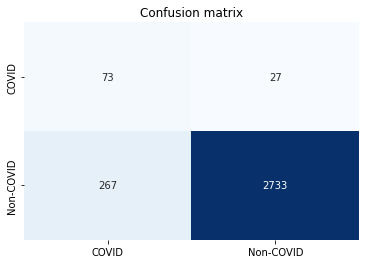

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

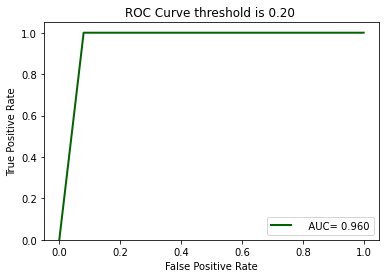

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

## **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 38
num of samples non covid but predicted covid : 172
total cases that predicted as covid:  234
total cases that predicted as non covid : 2866
Sensitivity is : 0.62
Specificity is : 0.9426666666666667


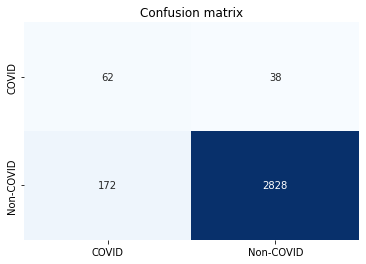

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

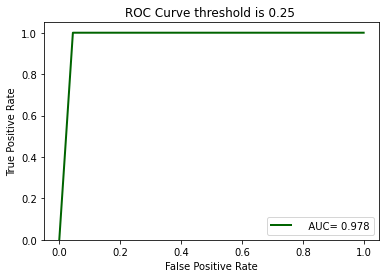

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

## **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 43
num of samples non covid but predicted covid : 112
total cases that predicted as covid:  169
total cases that predicted as non covid : 2931
Sensitivity is : 0.57
Specificity is : 0.9626666666666667


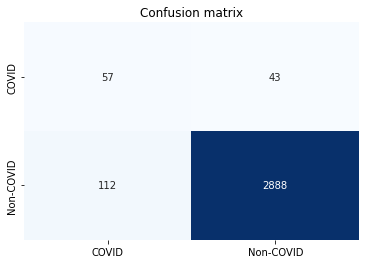

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.30)

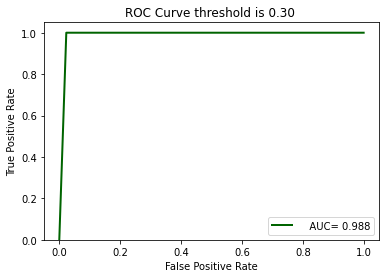

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.30)

## **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 49
num of samples non covid but predicted covid : 72
total cases that predicted as covid:  123
total cases that predicted as non covid : 2977
Sensitivity is : 0.51
Specificity is : 0.976


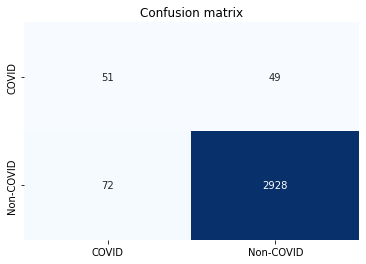

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

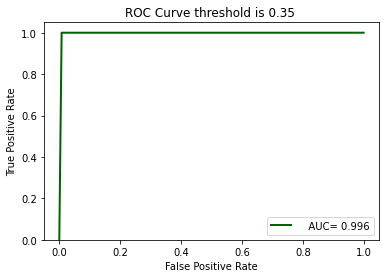

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

# **2nd Densenet121**

In [ ]:
#### load model
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
for param in model_conv.features.denseblock4.denselayer16.parameters():
    param.requires_grad = True
for param in model_conv.features.norm5.parameters():
    param.requires_grad = True
        
        

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.classifier.in_features        
model_conv.classifier = nn.Linear(num_ftrs, 2)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_densnet121_epoch100_2.pt')




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 0.850 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.850 


preds: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 0.850 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 0.800 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_densnet121_unet.pt' 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']

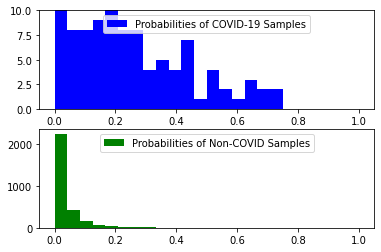

In [ ]:
Probabilties(covid_prob , non_prob)

## **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 43
num of samples non covid but predicted covid : 91
total cases that predicted as covid:  148
total cases that predicted as non covid : 2952
Sensitivity is : 0.57
Specificity is : 0.9696666666666667


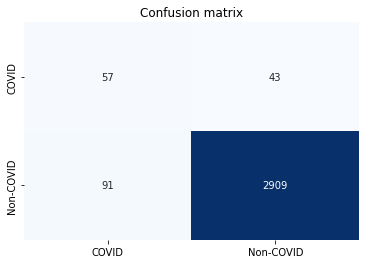

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

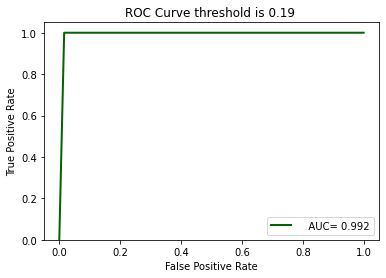

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

## **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 57
num of samples non covid but predicted covid : 48
total cases that predicted as covid:  91
total cases that predicted as non covid : 3009
Sensitivity is : 0.43
Specificity is : 0.984


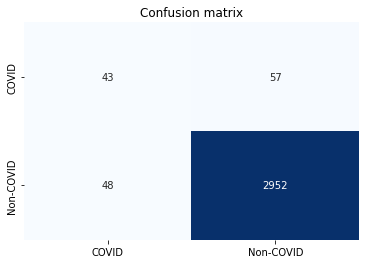

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

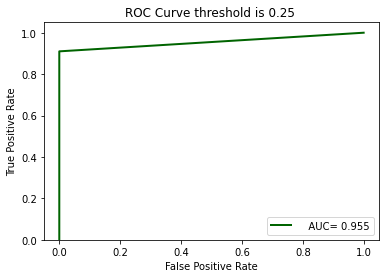

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

## **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 65
num of samples non covid but predicted covid : 34
total cases that predicted as covid:  69
total cases that predicted as non covid : 3031
Sensitivity is : 0.35
Specificity is : 0.9886666666666667


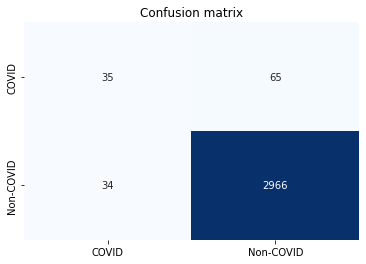

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

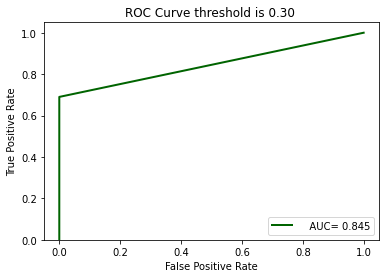

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

## **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 76
num of samples non covid but predicted covid : 16
total cases that predicted as covid:  40
total cases that predicted as non covid : 3060
Sensitivity is : 0.24
Specificity is : 0.9946666666666667


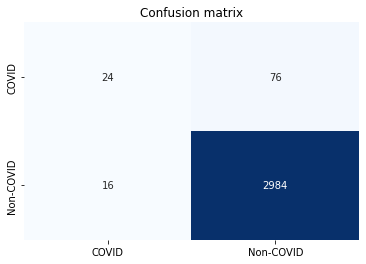

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

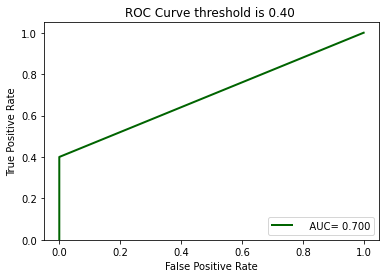

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)